<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/lvm/vae_celeba_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder for CelebA






## Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import pickle

from IPython import display

TensorFlow 2.x selected.


# Load the data from github


For training the VAE, we can use a tf.data.Dataset, but after training,
we need random access to the image files, so we can visualize the effects
of changing individual attributes. Hence we download a zipfile of images
that have been preprocessed to 64x64 using the script at
https://github.com/probml/pyprobml/blob/master/scripts/celeba_kaggle_preprocess.py



In [0]:
N = 40000 #200
H = 64; W = 64; C = 3;
input_shape = [H, W, 3]
name = 'celeba_small_H{}_W{}_N{}'.format(H, W, N)
csv_name = '{}.csv'.format(name)
zip_name = '{}.zip'.format(name)

In [3]:
!rm {csv_name}
#!wget https://github.com/probml/pyprobml/blob/master/data/celeba_small_H64_W64_N20.csv
#!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/celeba_small_H64_W64_N20.csv
!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/{csv_name}  

rm: cannot remove 'celeba_small_H64_W64_N40000.csv': No such file or directory
--2019-09-06 14:28:10--  https://raw.githubusercontent.com/probml/pyprobml/master/data/celeba_small_H64_W64_N40000.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4879946 (4.7M) [text/plain]
Saving to: ‘celeba_small_H64_W64_N40000.csv’

celeba_small_H64_W6 100%[===================>]   4.65M  --.-KB/s    in 0.1s    

2019-09-06 14:28:11 (39.9 MB/s) - ‘celeba_small_H64_W64_N40000.csv’ saved [4879946/4879946]



In [4]:
import pandas as pd
df = pd.read_csv(csv_name)
df.head()


image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1

[5 rows x 41 columns]

In [5]:
N = len(df)
print(N)

40000


In [6]:
!rm {zip_name}
!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/{zip_name}
  

rm: cannot remove 'celeba_small_H64_W64_N40000.zip': No such file or directory
--2019-09-06 14:28:25--  https://raw.githubusercontent.com/probml/pyprobml/master/data/celeba_small_H64_W64_N40000.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68275845 (65M) [application/zip]
Saving to: ‘celeba_small_H64_W64_N40000.zip’

celeba_small_H64_W6 100%[===================>]  65.11M   156MB/s    in 0.4s    

2019-09-06 14:28:29 (156 MB/s) - ‘celeba_small_H64_W64_N40000.zip’ saved [68275845/68275845]



In [7]:
!rm *.jpg
!ls

rm: cannot remove '*.jpg': No such file or directory
celeba_small_H64_W64_N40000.csv  celeba_small_H64_W64_N40000.zip  sample_data


In [8]:
!unzip {zip_name}

Archive:  celeba_small_H64_W64_N40000.zip
  inflating: 003301.jpg              
  inflating: 013112.jpg              
  inflating: 005770.jpg              
  inflating: 015563.jpg              
  inflating: 024966.jpg              
  inflating: 019359.jpg              
  inflating: 001516.jpg              
  inflating: 030913.jpg              
  inflating: 039089.jpg              
  inflating: 011705.jpg              
  inflating: 006279.jpg              
  inflating: 008254.jpg              
  inflating: 028184.jpg              
  inflating: 007167.jpg              
  inflating: 000608.jpg              
  inflating: 018047.jpg              
  inflating: 038397.jpg              
  inflating: 017374.jpg              
  inflating: 018721.jpg              
  inflating: 026817.jpg              
  inflating: 017412.jpg              
  inflating: 008532.jpg              
  inflating: 039937.jpg              
  inflating: 007601.jpg              
  inflating: 011063.jpg              
  inflat

In [9]:
from glob import glob
filenames = glob('*.jpg')
#print(filenames) # should match df['image_id']
print(len(filenames))

40000


In [0]:
from matplotlib.image import imread
images = np.zeros((N, H, W, C), dtype=np.float32) # pre-allocate memory
for i in range(N):
    filename = df.iloc[i]['image_id']
    img = imread(filename) # numpy array of uint8
    images[i,:,:,:] = img / 255 # float in 0..1

(3, 64, 64, 3)


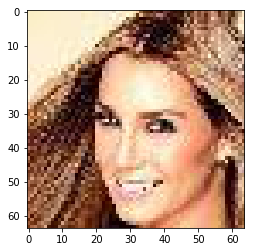

In [11]:
Xsmall = images[:3, :, :, :]
print(Xsmall.shape)
plt.imshow(Xsmall[0])



In [0]:
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices(images)
train_dataset = (dataset
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))

test_dataset= train_dataset
num_colors = 3


# Define model

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [0]:
def make_encoder(
        input_dim,
        z_dim,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        use_batch_norm = False,
        use_dropout= False
        ):
  encoder_input = Input(shape=input_dim, name='encoder_input')
  x = encoder_input
  n_layers_encoder = len(encoder_conv_filters)
  for i in range(n_layers_encoder):
      conv_layer = Conv2D(
          filters = encoder_conv_filters[i]
          , kernel_size = encoder_conv_kernel_size[i]
          , strides = encoder_conv_strides[i]
          , padding = 'same'
          , name = 'encoder_conv_' + str(i)
          )
      x = conv_layer(x)
      if use_batch_norm:
          x = BatchNormalization()(x)
      x = LeakyReLU()(x)
      if use_dropout:
          x = Dropout(rate = 0.25)(x)
  shape_before_flattening = K.int_shape(x)[1:]
  x = Flatten()(x)
  mu = Dense(z_dim, name='mu')(x) # no activation
  log_var = Dense(z_dim, name='log_var')(x) # no activation
  encoder = Model(encoder_input, (mu, log_var))
  return encoder, shape_before_flattening



In [0]:
def make_decoder(
        shape_before_flattening,
        z_dim,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        use_batch_norm = False,
        use_dropout= False
        ):
  decoder_input = Input(shape=(z_dim,), name='decoder_input')
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)
  n_layers_decoder = len(decoder_conv_t_filters)
  for i in range(n_layers_decoder):
      conv_t_layer = Conv2DTranspose(
          filters = decoder_conv_t_filters[i]
          , kernel_size = decoder_conv_t_kernel_size[i]
          , strides = decoder_conv_t_strides[i]
          , padding = 'same'
          , name = 'decoder_conv_t_' + str(i)
          )
      x = conv_t_layer(x)
      if i < n_layers_decoder - 1:
          if use_batch_norm:
              x = BatchNormalization()(x)
          x = LeakyReLU()(x)
          if use_dropout:
              x = Dropout(rate = 0.25)(x)
      # No activation fn in final layer since returns logits
      #else:
      #    x = Activation('sigmoid')(x)
  decoder_output = x
  decoder = Model(decoder_input, decoder_output)
  return decoder
  


In [0]:

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def sample_gauss(mean, logvar):
  eps = tf.random.normal(shape=mean.shape)
  return eps * tf.exp(logvar * .5) + mean

In [0]:
class ConvVAE(tf.keras.Model):
  def __init__(self,
        input_dim,
        latent_dim,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        use_batch_norm = False,
        use_dropout= False,
        recon_loss_scaling = 1,
        kl_loss_scaling = 1,
        use_mse_loss = False
        ):
    super(ConvVAE, self).__init__()
    # Save all args so we can reconstruct this object later
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.encoder_conv_filters = encoder_conv_filters
    self.encoder_conv_kernel_size = encoder_conv_kernel_size
    self.encoder_conv_strides = encoder_conv_strides
    self.decoder_conv_t_filters = decoder_conv_t_filters
    self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
    self.decoder_conv_t_strides = decoder_conv_t_strides
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout
    self.recon_loss_scaling = recon_loss_scaling
    self.kl_loss_scaling = kl_loss_scaling
    self.use_mse_loss = use_mse_loss
    
    self.inference_net, self.shape_before_flattening = make_encoder(
        input_dim,
        latent_dim,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        use_batch_norm,
        use_dropout)
    
    self.generative_net = make_decoder(
        self.shape_before_flattening,
        latent_dim,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        use_batch_norm,
        use_dropout)

  @tf.function
  def sample(self, nsamples=1):
    eps = tf.random.normal(shape=(nsamples, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode_stochastic(self, x):
    mean, logvar = self.inference_net(x)
    return sample_gauss(mean, logvar)

  def decode(self, z, apply_sigmoid=True):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits
  
  
  @tf.function
  def compute_loss(self, x):
    mean, logvar = self.inference_net(x)
    z = sample_gauss(mean, logvar)
    if self.use_mse_loss:
      x_probs = self.decode(z, apply_sigmoid=True)
      mse = tf.reduce_mean( (x - x_probs) ** 2, axis=[1, 2, 3])
      logpx_z = -0.5*mse # log exp(-0.5 (x-mu)^2)
    else:
      x_logit = self.decode(z, apply_sigmoid=False)
      cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x) # -sum_{c=0}^1 p_c log q_c
      logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # sum over H,W,C
    logpz = log_normal_pdf(z, 0., 0.) # prior: mean=0, logvar=0
    logqz_x = log_normal_pdf(z, mean, logvar)
    kl_loss = logpz - logqz_x # MC approximation
    return -tf.reduce_mean(self.recon_loss_scaling * logpx_z + self.kl_loss_scaling * kl_loss) # -ve ELBO


          
  @tf.function
  def compute_gradients(self, x):
    with tf.GradientTape() as tape:
      loss = self.compute_loss(x)
    gradients = tape.gradient(loss, self.trainable_variables)
    return gradients


In [0]:

# Use parameters from
#https://nbviewer.jupyter.org/github/davidADSP/GDL_code/blob/master/03_05_vae_faces_train.ipynb
R_LOSS_FACTOR = 10000
latent_dim = 200

model = ConvVAE(
                input_dim = input_shape
                , latent_dim = latent_dim
                , encoder_conv_filters=[32,64,64, 64]
                , encoder_conv_kernel_size=[3,3,3,3]
                , encoder_conv_strides=[2,2,2,2]
                , decoder_conv_t_filters=[64,64,32,3]
                , decoder_conv_t_kernel_size=[3,3,3,3]
                , decoder_conv_t_strides=[2,2,2,2]
                , use_batch_norm=True
                , use_dropout=True
                , use_mse_loss = True
                , recon_loss_scaling = R_LOSS_FACTOR)

In [19]:
# Test
M, V = model.inference_net(Xsmall)
print(M.shape)
print(V.shape)

Z = model.encode_stochastic(Xsmall)
print(Z.shape)

predictions = model.decode(Z)
print(Z.shape)
print(predictions.shape)


(3, 200)
(3, 200)
(3, 200)
(3, 200)
(3, 64, 64, 3)


In [20]:
L = model.compute_loss(Xsmall)
print(L)
g = model.compute_gradients(Xsmall)
print(g[0].shape) # 3,3,ncolors,32 - size of first layer conv

tf.Tensor(321.67044, shape=(), dtype=float32)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(3, 3, 3, 32)


# Code to save model 

Before we start training, make sure we can save and load model...


In [0]:
  
# Save args to class constructor as pkl file
# and weights as hd5 file

def save_vae(model, folder):
    with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
        pickle.dump([
            model.input_dim,
            model.latent_dim,
            model.encoder_conv_filters,
            model.encoder_conv_kernel_size,
            model.encoder_conv_strides,
            model.decoder_conv_t_filters,
            model.decoder_conv_t_kernel_size,
            model.decoder_conv_t_strides,
            model.use_batch_norm,
            model.use_dropout,
            model.recon_loss_scaling,
            model.kl_loss_scaling,
            model.use_mse_loss
            ], f)
    model.save_weights(os.path.join(folder, 'weights.h5'))
    

# Generic model loader
def load_model(model_class, folder):
    with open(os.path.join(folder, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)
    model = model_class(*params)
    model.load_weights(os.path.join(folder, 'weights.h5'))
    return model





In [0]:
folder = 'vae_celeba'
if not os.path.exists(folder):
      os.makedirs(folder)
    
save_vae(model, folder)    

In [23]:
# Check new model gives same results as old model 
model_new = load_model(ConvVAE, folder)

M, V = model.inference_net(Xsmall)
M_new, V_new = model_new.inference_net(Xsmall)
np.allclose(M, M_new)

True

In [0]:
!ls {folder}

params.pkl  weights.h5


In [0]:
# Save out of colab
from google.colab import files
files.download(os.path.join(folder, 'params.pkl'))
files.download(os.path.join(folder, 'weights.h5'))


In [0]:
# Save some data so we can test externally that we get exactly the same predicitons

with open(os.path.join(folder, 'celeba_small.pkl'), 'wb') as f:
     pickle.dump(Xsmall, f)
  
files.download(os.path.join(folder, 'celeba_small.pkl'))  

# Training


Epoch 0, Test loss: 445.10306, time 42.00


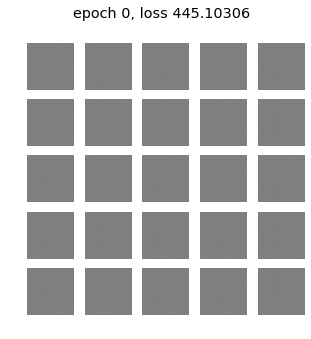

In [24]:

# Callback
def generate_images(model, epoch, noise_vector):
  predictions = model.decode(noise_vector)
  n = int(np.sqrt(num_examples_to_generate))
  fig = plt.figure(figsize=(n,n))
  for i in range(predictions.shape[0]):
      plt.subplot(n, n, i+1)
      if num_colors == 1:
         plt.imshow(predictions[i, :, :, 0], cmap='gray')
      else:
         plt.imshow(predictions[i, :, :, :])
      plt.axis('off')
  
  
num_examples_to_generate = 25 # 16
# We use fixed noise vector to generate samples during training so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, model.latent_dim])

# we assume model.compute_loss(batch) is defined
# as well as test_dataset
def callback(model, epoch, elapsed_time, print_every_n_epoch=5):
  loss_tracker = tf.keras.metrics.Mean()
  for batch in test_dataset:
    loss_tracker(model.compute_loss(batch))
  test_loss = loss_tracker.result()
  #display.clear_output(wait=False) # don't erase old outputs
  print('Epoch {}, Test loss: {:0.5f}, time {:0.2f}'.format(
            epoch, test_loss, elapsed_time)) 
  if epoch % print_every_n_epoch == 0:
    generate_images(model, epoch, random_vector_for_generation)
    plt.suptitle('epoch {}, loss {:0.5f}'.format(epoch, test_loss), fontsize='x-large')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

  
# Test 
callback(model, 0, 42)

In [0]:
# generic (model agnostic) training function.
# model must support these methods:
# g = model.compute_gradients(X)
# model.traininable_variables (so model is a subclass of Keras.Model)

# Callback has following interface: callback(model, epoch, elapsed_time)

def train_model(model, optimizer, train_dataset,
                epochs, callback=None):
  for epoch in range(0, epochs):
    start_time = time.time()
    for batch in train_dataset:
      gradients = model.compute_gradients(batch)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    end_time = time.time()
    elapsed_time = end_time - start_time
    if callback:
       callback(model, epoch, elapsed_time)                               
  return model

Epoch 0, Test loss: 136.88654, time 23.08


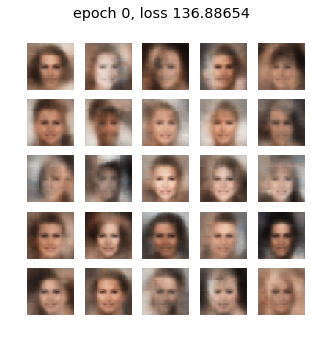

Epoch 1, Test loss: 125.66066, time 20.91
Epoch 2, Test loss: 122.71965, time 21.11
Epoch 3, Test loss: 120.58813, time 21.27
Epoch 4, Test loss: 119.16476, time 21.32
Epoch 5, Test loss: 118.03262, time 21.53


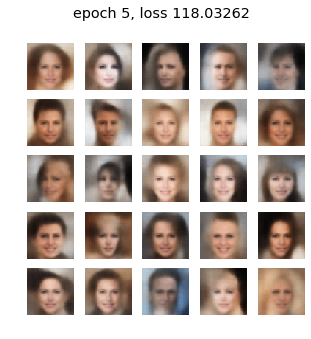

Epoch 6, Test loss: 117.71300, time 20.83
Epoch 7, Test loss: 116.94132, time 20.92
Epoch 8, Test loss: 116.47766, time 21.13
Epoch 9, Test loss: 116.16115, time 20.98
Epoch 10, Test loss: 115.68378, time 21.46


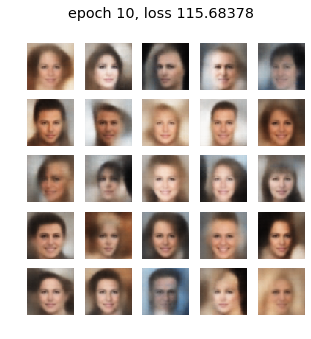

Epoch 11, Test loss: 115.73238, time 21.30
Epoch 12, Test loss: 115.50919, time 20.87
Epoch 13, Test loss: 114.87856, time 21.04
Epoch 14, Test loss: 114.71289, time 21.17
Epoch 15, Test loss: 114.55794, time 21.16


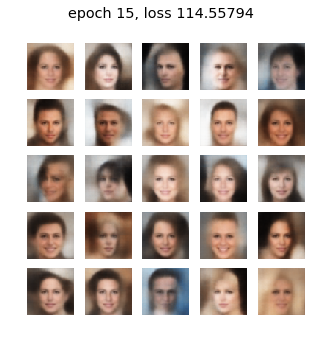

Epoch 16, Test loss: 114.43752, time 21.25
Epoch 17, Test loss: 113.82818, time 21.04
Epoch 18, Test loss: 113.97665, time 21.38
Epoch 19, Test loss: 113.79597, time 21.36
Epoch 20, Test loss: 113.60280, time 22.51


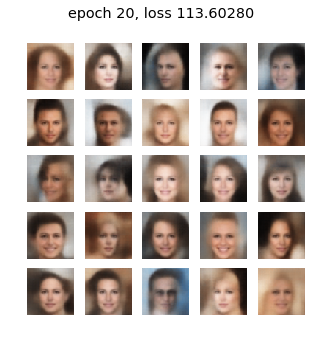

Epoch 21, Test loss: 113.84341, time 22.55
Epoch 22, Test loss: 113.04102, time 22.73
Epoch 23, Test loss: 113.66743, time 22.27
Epoch 24, Test loss: 113.13232, time 22.48
Epoch 25, Test loss: 113.42483, time 22.28


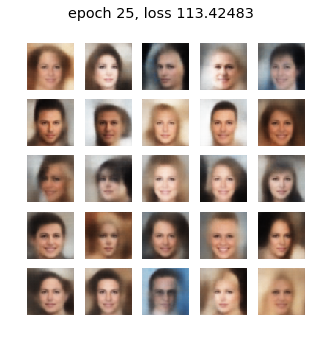

Epoch 26, Test loss: 112.80672, time 22.60
Epoch 27, Test loss: 112.74601, time 22.41
Epoch 28, Test loss: 112.90327, time 22.33
Epoch 29, Test loss: 112.54247, time 22.34


In [26]:
optimizer = tf.keras.optimizers.Adam(1e-3)
epochs = 30

model = train_model(model, optimizer, train_dataset, epochs, callback)

In [0]:
save_vae(model, folder)


In [33]:
!ls {folder}

params.pkl  weights.h5


In [0]:
from google.colab import files
files.download(os.path.join(folder, 'params.pkl')) # store outside of colab - execute cell twice

In [0]:

files.download(os.path.join(folder, 'weights.h5')) # store outside of colab

# Post-training

# Latent space analysis

Illustrate latent space embedding and arithmetic for  VAE on CelebA faces images
Code is based on 
 https://nbviewer.jupyter.org/github/davidADSP/GDL_code/blob/master/03_06_vae_faces_analysis.ipynb

In [0]:
# Make some wrapper functions so we can reuse code from
# https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_faces_analysis.ipynb
  
INPUT_DIM = input_shape
DATA_FOLDER = ''
IMAGE_FOLDER = ''
vae = model

def vae_encode(model, x):
    mean, logvar = model.inference_net(x)
    return mean

def vae_decode(model, z_points):
    return model.decode(z_points)


In [36]:
att = pd.read_csv(csv_name)
att.head()


image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1

[5 rows x 41 columns]

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class ImageLabelLoader():
    def __init__(self, image_folder, target_size):
        self.image_folder = image_folder
        self.target_size = target_size

    def build(self, att, batch_size, label = None):

        data_gen = ImageDataGenerator(rescale=1./255)
        if label:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , y_col=label
                , target_size=self.target_size 
                , class_mode='other'
                , batch_size=batch_size
                , shuffle=True
            )
        else:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , target_size=self.target_size 
                , class_mode='input'
                , batch_size=batch_size
                , shuffle=True
            )

        return data_flow

In [0]:
imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

## Reconstruction

Found 40000 validated image filenames.


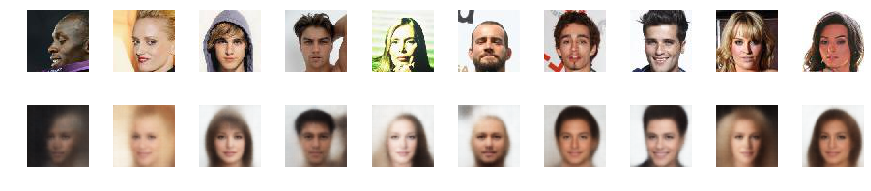

In [39]:
# Reconstruct some images
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = vae_encode(vae, example_images)
reconst_images = vae_decode(vae, z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#fig.subplots_adjust(hspace=0, wspace=0.1)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)
   
for i in range(n_to_show):
    img = reconst_images[i].numpy().squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)
    



In [0]:
from numpy import array,flipud,shape,zeros,rot90,ceil,floor,sqrt

def montage(X):    
    count = len(X)
    m, n, c = X[0].shape    
    mm = int(ceil(sqrt(count)))
    nn = mm
    M = zeros((mm * m, nn * n, c))

    image_id = 0
    for j in range(mm):
        for k in range(nn):
            if image_id >= count: 
                break
            sliceM, sliceN = j * m, k * n
            M[sliceN:sliceN + n, sliceM:sliceM + m, :] = X[image_id]
            image_id += 1
                    
    plt.imshow(M)
    plt.axis('off')    

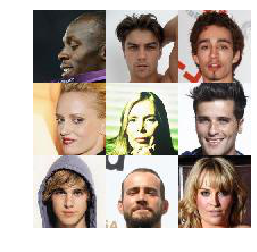

In [41]:
#imgs = [example_images[i].squeeze() for i in range(n_to_show)]
imgs = [example_images[i].squeeze() for i in range(9)]
montage(imgs)



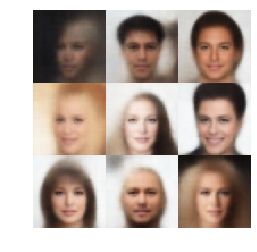

In [50]:
imgs = [reconst_images[i].numpy().squeeze() for i in range(9)]
montage(imgs)

## Generation

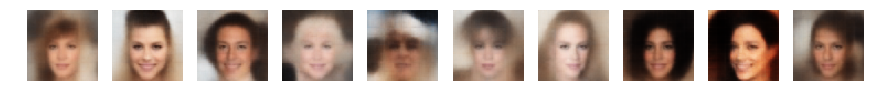

In [46]:
# Newly generated faces
n_to_show = 10 #30

znew = np.random.normal(size = (n_to_show, latent_dim))
samples = vae_decode(vae, np.array(znew))

fig = plt.figure(figsize=(15,3))
for i in range(n_to_show):
  ax = fig.add_subplot(1, 10, i+1)
  ax.imshow(samples[i, :,:,:])
  ax.axis('off')

plt.show()

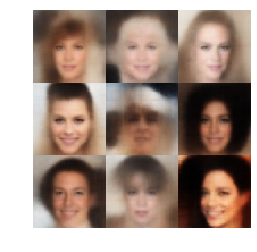

In [49]:
imgs = [samples[i].numpy().squeeze() for i in range(9)]
montage(imgs)

## Arithmetic in latent space

In [0]:


def get_vector_from_label(model, label, batch_size=500, att=att):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    #origin = np.zeros(shape = latent_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = latent_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = latent_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = latent_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = latent_dim, dtype = 'float32')

    current_vector = np.zeros(shape = latent_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae_encode(model, np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


def add_vector_to_images(model, feature_vec, att=att):
    n_to_show = 4
    data_flow_generic = imageLoader.build(att, n_to_show)
    #factors = [-4,-3,-2,-1,0,1,2,3,4]
    factors = [-4,-2,0,2,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    #example_labels = example_batch[1]

    z_points = vae_encode(model, example_images)

    fig = plt.figure() #figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae_decode(model, np.array([changed_z_point]))[0]

            img = changed_image.numpy().squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()


In [52]:
print('Eyeglasses Vector')
eyeglasses_vec = get_vector_from_label(model, 'Eyeglasses')


Eyeglasses Vector
Found 40000 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
40    : 1.566    : 0.484    : 1.69    : 1.69
78    : 0.695    : 0.17    : 1.553    : -0.137
112    : 0.351    : 0.112    : 1.591    : 0.037
147    : 0.183    : 0.102    : 1.513    : -0.077
173    : 0.183    : 0.058    : 1.488    : -0.025
212    : 0.193    : 0.046    : 1.495    : 0.006
253    : 0.138    : 0.036    : 1.468    : -0.027
278    : 0.087    : 0.03    : 1.466    : -0.002
310    : 0.119    : 0.03    : 1.432    : -0.034
335    : 0.078    : 0.027    : 1.43    : -0.002
353    : 0.074    : 0.027    : 1.412    : -0.018
383    : 0.075    : 0.019    : 1.422    : 0.01
416    : 0.087    : 0.017    : 1.425    : 0.003
450    : 0.087    : 0.016    : 1.412    : -0.013
487    : 0.067    : 0.022    : 1.427    : 0.015
521    : 0.067    : 0.013    : 1.42    : -0.007
551    : 0.057    : 0.015    : 1.41    : -0.01
Found the Eyeglasses vector


Found 40000 validated image filenames.


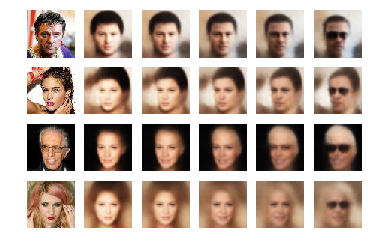

In [56]:
add_vector_to_images(model, eyeglasses_vec)

In [57]:

print('Male Vector')
male_vec = get_vector_from_label(model, 'Male')


Male Vector
Found 40000 validated image filenames.
label: Male
images : POS move : NEG move :distance : 𝛥 distance
210    : 0.714    : 0.702    : 1.144    : 1.144
406    : 0.229    : 0.179    : 1.096    : -0.048
627    : 0.143    : 0.133    : 1.098    : 0.002
842    : 0.098    : 0.092    : 1.091    : -0.006
1065    : 0.078    : 0.063    : 1.076    : -0.016
1262    : 0.062    : 0.063    : 1.075    : -0.001
1457    : 0.057    : 0.041    : 1.082    : 0.008
1668    : 0.042    : 0.038    : 1.077    : -0.005
1858    : 0.043    : 0.036    : 1.079    : 0.002
Found the Male vector


Found 40000 validated image filenames.


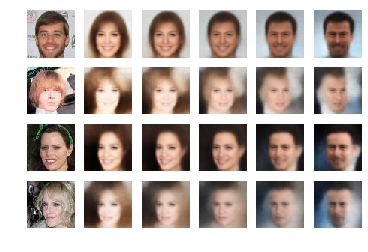

In [62]:
add_vector_to_images(model, male_vec)

## Face interpolation

In [0]:
def morph_faces(model, start_image_file, end_image_file, att=att):

    #factors = np.arange(0, 1, 0.1)
    factors = np.arange(0, 1, 0.2)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    #example_labels = example_batch[1]

    z_points = vae_encode(model, example_images)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1
    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae_decode(model, np.array([changed_z_point]))[0]

        img = changed_image.numpy().squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()




Found 2 validated image filenames.


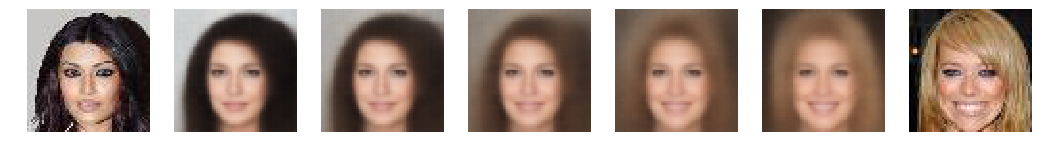

In [64]:

start_image_file = '000112.jpg' # blonde
end_image_file = '000258.jpg' # brunette
morph_faces(model, start_image_file, end_image_file)

Found 2 validated image filenames.


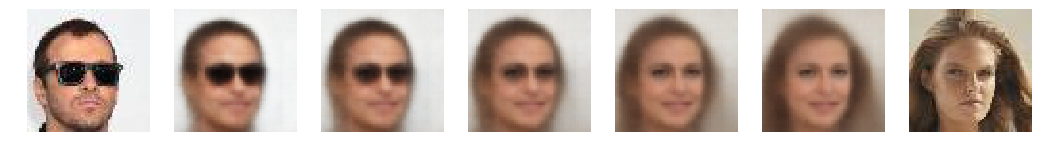

In [65]:
start_image_file = '000238.jpg'  #male, glasses
end_image_file = '000193.jpg' #female
morph_faces(model, start_image_file, end_image_file)



Found 2 validated image filenames.


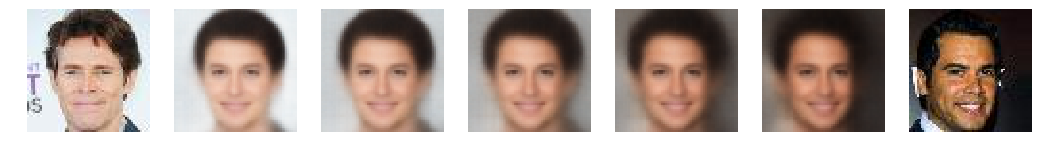

In [66]:
start_image_file = '000230.jpg' # male
end_image_file = '000712.jpg' # male
morph_faces(model, start_image_file, end_image_file)